In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os,sys,glob, json
import _pickle as pkl
import dlab
from tqdm.notebook import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import matplotlib 
matplotlib.rcParams.update({'figure.max_open_warning': 0})

In [35]:
recording_folder = r'G:/Grant/rotation/2023-09-29_16-07-39_PaBont2'
# recording_folder = '/Volumes/s2/Grant/rotation/2023-09-29_16-07-39_PaBont2'

experimenter = 'grh'
experiment_description= 'Denman Lab, University of Colorado Anschutz. Test of PaBoNT axon silencing of V1 axons'

# #spikeglx
# probes = [os.path.basename(f) for f in np.sort(glob.glob(recording_folder+'/*-AP*'))]

probeids = ['A','B','C'] 
probedepths = [1050,1050,3450] 

In [45]:
stim_path = r'G:/Grant/rotation/2023-09-29_16-07-39_PaBont2/stim'
gratings_pkl = pkl.load(open(glob.glob(stim_path+'/*gratings_o*')[0],'rb'))
gratings_pkl_o = pkl.load(open(glob.glob(stim_path+'/*gratings_o*')[1],'rb'))

scene_pkl = pkl.load(open(glob.glob(stim_path+'/*scene_f*')[0],'rb'))
scene_pkl_o = pkl.load(open(glob.glob(stim_path+'/*scene_f*')[1],'rb'))

image_start_frame = [int(start_frame) for start_frame,end_frame in scene_pkl['bgsweepframes']]
image_start_frame_o = [int(start_frame) for start_frame,end_frame in scene_pkl_o['bgsweepframes']]
image_order = scene_pkl['bgsweeporder']
image_order_o = scene_pkl_o['bgsweeporder']

In [51]:
from open_ephys.analysis import Session

directory = recording_folder # for example

session = Session(recording_folder)

In [52]:
events_df = pd.DataFrame(session.recordnodes[0].recordings[0].events)#

In [53]:
session.recordnodes[0].recordings[0].events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
0,1,101492653,3386.402741,106,4,ProbeC-AP,0
1,1,8457752,3386.402776,106,3,ProbeB-LFP,0
2,1,101493035,3386.402875,106,2,ProbeB-AP,0
3,1,101492903,3386.402884,106,0,ProbeA-AP,0
4,8,101599890,3386.402900,107,6,PXI-6133,0
...,...,...,...,...,...,...,...
836186,1,25407903,10173.222491,106,3,ProbeB-LFP,0
836187,1,25407869,10173.222800,106,1,ProbeA-LFP,0
836188,1,304894840,10173.223351,106,2,ProbeB-AP,0
836189,1,304893672,10173.223528,106,4,ProbeC-AP,0


In [54]:
ni_df = events_df[events_df.stream_name == 'PXI-6133' ]

In [55]:
ni_df

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
4,8,101599890,3386.402900,107,6,PXI-6133,0
11,8,101614905,3386.903400,107,6,PXI-6133,1
15,8,101629920,3387.403900,107,6,PXI-6133,0
21,8,101644935,3387.904400,107,6,PXI-6133,1
28,8,101659950,3388.404900,107,6,PXI-6133,0
...,...,...,...,...,...,...,...
835904,5,304513227,10150.181461,107,6,PXI-6133,0
835917,5,304543254,10151.182361,107,6,PXI-6133,1
835930,5,304573724,10152.198028,107,6,PXI-6133,0
835947,5,304603885,10153.203394,107,6,PXI-6133,1


In [56]:
ni_ts = {}
df_up = ni_df[ni_df.state==1]
for ch in ni_df.line.unique():
    ni_ts[ch] = df_up[df_up.line == ch].timestamp

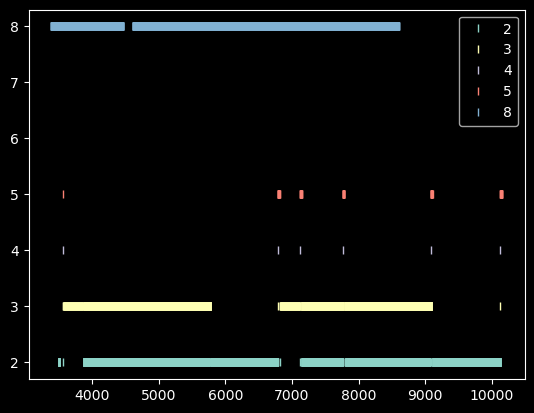

In [57]:
for ch in ([2,3,4,5,8]):
    plt.plot(np.array(ni_ts[ch]),
             np.ones(len(ni_ts[ch]))*ch,
             '|',label=ch)
plt.legend()
# plt.xlim(gratings_times.values[-1] -1, gratings_times.values[-1]+60)

In [62]:
# eye_camera_frame_times = ni_ts[7]
opto_df = ni_df[ni_df.line==5]
opto_off_times = opto_df[opto_df.state==0].timestamp
opto_on_times = opto_df[opto_df.state==1].timestamp

df_flash = ni_df[ni_df.line==3]
flash_times = df_flash[df_flash.state==1].timestamp[1:101]#first 100 are flash onset

arbMatrix_start_time = flash_times.values[-1]
df_strf = ni_df[ni_df.line==2]
arbMatrix_times = df_strf[df_strf.state==1].timestamp[df_strf[df_strf.state==1].timestamp > arbMatrix_start_time][:12000]

gratings_start_time = arbMatrix_times.values[-1]
df_gratings = ni_df[ni_df.line==2]
gratings_times = df_gratings[df_gratings.state==1].timestamp[df_gratings[df_gratings.state==1].timestamp > gratings_start_time][:640]

images_start_time = gratings_times.values[-1]
df_images = ni_df[ni_df.line==2]
images_times = df_images[df_images.state==1].timestamp[df_images[df_images.state==1].timestamp > images_start_time][:int(image_start_frame[-1])+1].values[image_start_frame]

df_flash_o = ni_df[ni_df.line==3]
flash_times_o = df_flash_o[df_flash_o.state==1].timestamp[df_flash_o[df_flash_o.state==1].timestamp > images_times[-1]][1:101]#first 100 are flash onset

arbMatrix_start_time_o = flash_times_o.values[-1]
df_strf_o = ni_df[ni_df.line==2]
arbMatrix_times_o = df_strf_o[df_strf_o.state==1].timestamp[df_strf_o[df_strf_o.state==1].timestamp > arbMatrix_start_time_o][:12000]

gratings_start_time_o = arbMatrix_times_o.values[-1]
df_gratings_o = ni_df[ni_df.line==2]
gratings_times_o = df_gratings_o[df_gratings_o.state==1].timestamp[df_gratings_o[df_gratings_o.state==1].timestamp > gratings_start_time_o][2:642]

images_start_time_o = gratings_times_o.values[-1]
df_images_o = ni_df[ni_df.line==2]
images_times_o = df_images_o[df_images_o.state==1].timestamp[df_images_o[df_images_o.state==1].timestamp > images_start_time_o][:int(image_start_frame_o[-1])+1].values[image_start_frame_o]




In [175]:
print(len(images_times))
df_gratings

1000


,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
1659,2,105151549,3504.791305,107,6,PXI-6133,1
1660,2,105151957,3504.804905,107,6,PXI-6133,0
1661,2,105151964,3504.805138,107,6,PXI-6133,1
1662,2,105152461,3504.821705,107,6,PXI-6133,0
1663,2,105152467,3504.821905,107,6,PXI-6133,1
...,...,...,...,...,...,...,...
835560,2,303727312,10123.984292,107,6,PXI-6133,1
835561,2,303727814,10124.001026,107,6,PXI-6133,0
835562,2,303727821,10124.001259,107,6,PXI-6133,1
835563,2,303728314,10124.017692,107,6,PXI-6133,0


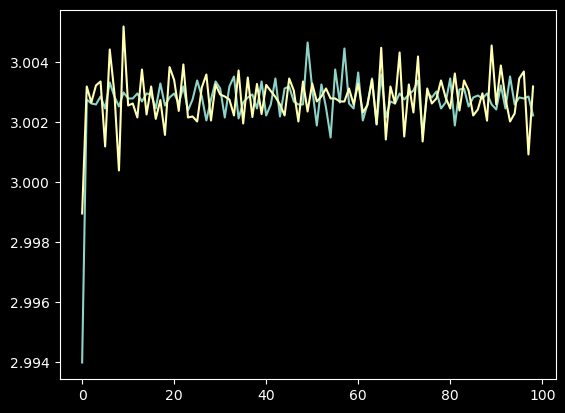

In [63]:
plt.plot(np.diff(flash_times))
plt.plot(np.diff(flash_times_o))

(0.0, 0.1)

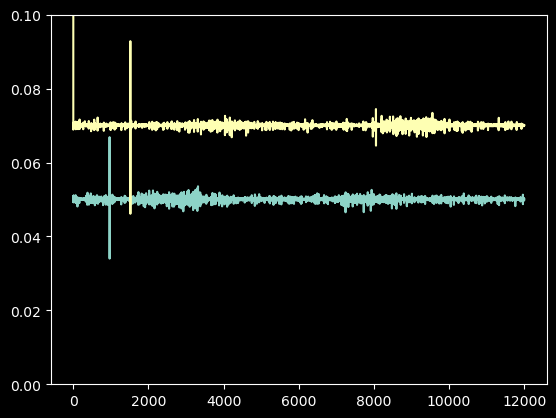

In [64]:
plt.plot(np.diff(arbMatrix_times))
plt.plot(np.diff(arbMatrix_times_o)+0.02)
plt.ylim(0,0.1)

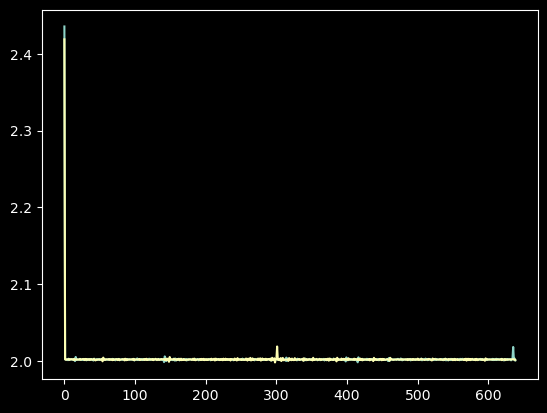

In [65]:
plt.plot(np.diff(gratings_times))
plt.plot(np.diff(gratings_times_o))
# plt.xlim(0,10)

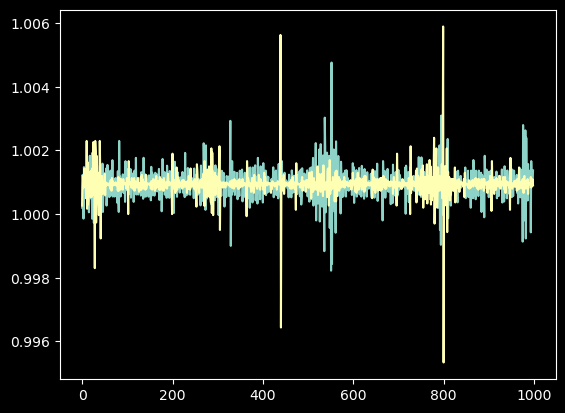

In [66]:
plt.plot(np.diff(images_times))
plt.plot(np.diff(images_times_o))
# plt.xlim(0,10)

In [95]:
stimuli_times = {'luminance_flash':flash_times,
                'spatioluminance_noise':arbMatrix_times,
                'gratings':gratings_times,
                'scenes':images_times,
                'luminance_flash_opto':flash_times_o,
                'spatioluminance_noise_opto':arbMatrix_times_o,
                'gratings_opto':gratings_times_o,
                'scenes_opto':images_times_o,
                  }

In [96]:
#finish loading the stimuli
arbMatrix_matrix = pkl.load(open(np.sort(glob.glob(stim_path+'/*'))[0],'rb'))
arbMatrix_matrix_o = pkl.load(open(np.sort(glob.glob(stim_path+'/*'))[1],'rb'))


#stimulus list
stimuli = {'luminance_flash':None,
            'spatioluminance_noise':arbMatrix_matrix,
            'gratings':gratings_pkl,
            'scenes':image_order,
            'luminance_flash_opto':None,
            'spatioluminance_noise_opto':arbMatrix_matrix_o,
            'gratings_opto':gratings_pkl_o,
            'scenes_opto':image_order_o,
           } 

## Assemble NWB

In [98]:
# !pip install pynwb

Defaulting to user installation because normal site-packages is not writeable

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



  Obtaining dependency information for pynwb from https://files.pythonhosted.org/packages/ce/3c/f2e265900fa86aadd5c111382149543c112e12c8caa4361de55db90dda37/pynwb-2.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for hdmf>=3.9.0 from https://files.pythonhosted.org/packages/00/fe/854583eb6cf0d3f1bc99cf500c8202ef9e9f0cdf78cda3f9e7dfcff8aed7/hdmf-3.10.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/134.0 kB ? eta -:--:--
   ---------------------------------------- 134.0/134.0 kB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/331.5 kB ? eta -:--:--
   --------------------------------------- 331.5/331.5 kB 20.1 MB/s eta 0:00:00


In [99]:
import pynwb
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.utils import StrDataset

In [100]:
from datetime import datetime
from dateutil.tz import tzlocal
from pynwb import NWBFile

nwbfile = NWBFile('Axon silencing with PaBoNT; PaBoNT_2', 
                  recording_folder, 
                  datetime.now(tzlocal()),
                  experimenter=experimenter,
                  lab='Denman Lab',
                  institution='University of Colorado',
                  experiment_description=experiment_description,
                  session_id=os.path.basename(recording_folder))

add stimulus information

In [101]:
for stim in stimuli_times.keys():
    nwbfile.add_epoch(np.array(stimuli_times[stim])[0], 
                      np.array(stimuli_times[stim])[-1]+3.,
                      [stim])

In [102]:
nwbfile.add_trial_column('stimulus', 'the stimulus during this trial')

#optogenetics
nwbfile.add_trial_column('optogenetics_LED_state',    'whether or not the LED was on or off for this trial. 1=on,0=off. exact opto times are available in optogenetics_states field of NWB')

#flashCSD
nwbfile.add_trial_column('flash_luminance', 'the luminance of the flash on this trial. 1=bright,0=dark')

#gratings_orientation
nwbfile.add_trial_column('contrast', 'index of each trial into a matrix of images')
nwbfile.add_trial_column('temporal_frequency', 'index of each trial into a matrix of images')
nwbfile.add_trial_column('spatial_frequency', 'index of each trial into a matrix of images')
nwbfile.add_trial_column('orientation', 'index of each trial into a matrix of images')

#arbMatrix and scene flicker
nwbfile.add_trial_column('stimulus_index', 'index of each trial into a matrix or list of images')

stim_vals = {'optogenetics_LED_state':-1,
             'flash_luminance':-1,
             'contrast':-1,
             'temporal_frequency':-1,
             'spatial_frequency':-1,
             'orientation':-1,
             'stimulus_index':-1,}

lums = [0,1]#['white','black']
stim = 'luminance_flash'
for i,trial_start in enumerate(np.array(stimuli_times[stim])):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,
                      flash_luminance=lums[i%2],
                      optogenetics_LED_state=0,
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      stimulus_index = stim_vals['stimulus_index'],
                     )
stim = 'luminance_flash_opto'
for i,trial_start in enumerate(np.array(stimuli_times[stim])):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,
                      flash_luminance=lums[i%2],
                      optogenetics_LED_state=1,
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      stimulus_index = stim_vals['stimulus_index'],
                     )

stim = 'spatioluminance_noise'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])),stimulus=stim,
                      flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index=i,
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      optogenetics_LED_state = 0)

stim = 'spatioluminance_noise_opto'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])),stimulus=stim,
                      flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index=i,
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      optogenetics_LED_state = 1)
stim = 'gratings'
info = [stimuli[stim]['bgsweeptable'][ind] for ind in stimuli[stim]['bgsweeporder']]
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,
                        flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index = stim_vals['stimulus_index'],
                      contrast=info[i][0],
                     temporal_frequency=info[i][2],
                     spatial_frequency=info[i][3],
                     orientation=info[i][-2],
                     optogenetics_LED_state=0)

stim = 'gratings_opto'
info = [stimuli[stim]['bgsweeptable'][ind] for ind in stimuli[stim]['bgsweeporder']]
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,
                        flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index = stim_vals['stimulus_index'],
                      contrast=info[i][0],
                     temporal_frequency=info[i][2],
                     spatial_frequency=info[i][3],
                     orientation=info[i][-2],
                     optogenetics_LED_state=1)
                     
stim = 'scenes'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])),stimulus=stim,
                      flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index=stimuli[stim][i],
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      optogenetics_LED_state = 0)

stim = 'scenes_opto'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])),stimulus=stim,
                      flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index=stimuli[stim][i],
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      optogenetics_LED_state = 1)
    

In [103]:
df = nwbfile.trials.to_dataframe()

In [104]:
df

,start_time,stop_time,stimulus,optogenetics_LED_state,flash_luminance,contrast,temporal_frequency,spatial_frequency,orientation,stimulus_index
id,,,,,,,,,,
0,3570.826467,3573.829202,luminance_flash,0,0,-1,-1,-1.0,-1,-1
1,3573.820467,3576.823202,luminance_flash,0,1,-1,-1,-1.0,-1,-1
2,3576.823233,3579.825968,luminance_flash,0,0,-1,-1,-1.0,-1,-1
3,3579.825867,3582.828602,luminance_flash,0,1,-1,-1,-1.0,-1,-1
4,3582.828467,3585.831202,luminance_flash,0,0,-1,-1,-1.0,-1,-1
...,...,...,...,...,...,...,...,...,...,...
27475,10118.996425,10119.997369,scenes_opto,1,-1,-1,-1,-1.0,-1,15
27476,10119.997359,10120.998302,scenes_opto,1,-1,-1,-1,-1.0,-1,16
27477,10120.998259,10121.999202,scenes_opto,1,-1,-1,-1,-1.0,-1,17


In [1]:
filtered_df = df[df['stimulus'] == 'gratings']
filtered_df

NameError: name 'df' is not defined

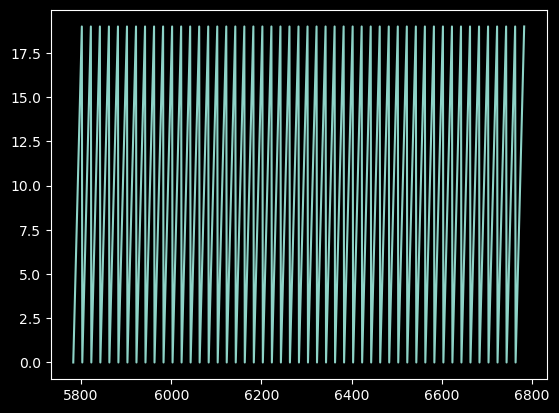

In [105]:
plt.plot(df[df.stimulus=='scenes'].start_time,df[df.stimulus=='scenes'].stimulus_index)

## add optogenetics

In [106]:
np.array(opto_off_times).shape[0]

77

In [107]:
opto_states = pynwb.epoch.TimeIntervals(
    name="optogenetics_states",
    description="intervals for optical fiber, fiber at power = 1.5AU on cyclops driver. fiber 565nm, ",
)

opto_states.add_column(name="power", description="power of fiber")
opto_states.add_column(name="wavelength", description="wavelength of light")

for i in range(np.array(opto_off_times).shape[0]):
    opto_states.add_row(start_time=np.array(opto_on_times)[i], stop_time=np.array(opto_off_times)[i], power=1.5, wavelength=565)

nwbfile.add_time_intervals(opto_states)

optogenetics_states pynwb.epoch.TimeIntervals at 0x2165803801552
Fields:
  colnames: ['start_time' 'stop_time' 'power' 'wavelength']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    power <class 'hdmf.common.table.VectorData'>,
    wavelength <class 'hdmf.common.table.VectorData'>
  )
  description: intervals for optical fiber, fiber at power = 1.5AU on cyclops driver. fiber 565nm, 
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

### add ephys data
first add electrodes and raw data link

In [108]:
from dlab.nwbtools import df_from_phy, load_phy_template, option234_positions, multi_load_unit_data


In [110]:
recording_folder = r'G:/Grant/rotation/2023-09-29_16-07-39_PaBont2/Record Node 103/experiment1/recording1/continuous'

In [111]:
df_units = multi_load_unit_data(recording_folder,probe_depths=probedepths)

KeyboardInterrupt: 

In [112]:
probes = ['A','B','C']
locations = ['VISp','VISl','VISa;CA1;DG;LP']
descriptions = ['Neuropixels1.0','Neuropixels1.0','Neuropixels1.0'] 

In [113]:
device = nwbfile.create_device(name='DenmanLab_EphysRig1')

for i, probe in enumerate(probes):
    electrode_name = 'probe'+str(i)
    description = descriptions[i]
    location = locations[i]

    electrode_group = nwbfile.create_electrode_group(electrode_name,
                                                     description=description,
                                                     location=location,
                                                     device=device)
    for ch in range(option234_positions.shape[0]):
        nwbfile.add_electrode(x=option234_positions[ch,0],y=0.,z=option234_positions[0,1],imp=0.0,location='none',filtering='high pass 300Hz',group=electrode_group)
    
#     if len(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')) > 0:
#         ephys_ts = pynwb.ecephys.ElectricalSeries('lfp_probe'+probeids[i],
#                                 data=H5DataIO(data=StrDataset(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')[0]),    
#                                         link_data=True),
#                                 electrodes = electrode_group,
#                                 starting_time=0,
#                                 rate=2500,
#                                 resolution=0.001,
#                                 comments="V1, depth = 1500um",
#                                 description="V1, depth = 1500um")
#         nwbfile.add_acquisition(ephys_ts)

In [114]:
nwbfile

root pynwb.file.NWBFile at 0x2165803495440
Fields:
  devices: {
    DenmanLab_EphysRig1 <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    probe0 <class 'pynwb.ecephys.ElectrodeGroup'>,
    probe1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    probe2 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  epoch_tags: {
    gratings,
    gratings_opto,
    luminance_flash,
    luminance_flash_opto,
    scenes,
    scenes_opto,
    spatioluminance_noise,
    spatioluminance_noise_opto
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: Denman Lab, University of Colorado Anschutz. Test of PaBoNT axon silencing of V1 axons
  experimenter: ['grh']
  file_create_date: [datetime.datetime(2023, 10, 10, 12, 21, 7, 495277, tzinfo=tzlocal())]
  identifier: G:/Grant/rotation/2023-09-29_16-07-39_PaBont2/Record Node 103/experiment1/recording1/continuous
  institution: University of Colorado
  intervals: {
    optogenetics_states <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: Denman Lab
  session_description: Axon silencing with PaBoNT; PaBoNT_2
  session_id: continuous
  session_start_time: 2023-10-10 12:21:07.494278-06:00
  timestamps_reference_time: 2023-10-10 12:21:07.494278-06:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'>

In [115]:
# nwbfile.add_unit_column('location', 'the anatomical location of this unit')
# nwbfile.add_unit_column('quality', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_ISIviolations', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_sn', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_distance', 'the quality for the inference of this unit')

nwbfile.add_unit_column('depth', 'the depth of this unit from the pia')
nwbfile.add_unit_column('xpos', 'the x position on probe')
nwbfile.add_unit_column('ypos', 'the y position on probe')
# nwbfile.add_unit_column('template', 'Kilosort template')
nwbfile.add_unit_column('label', 'user label')
nwbfile.add_unit_column('KSlabel', 'Kilosort label')
nwbfile.add_unit_column('KSamplitude', 'Kilosort amplitude')
nwbfile.add_unit_column('KScontamination', 'Kilosort ISI contamination')
nwbfile.add_unit_column('probe', 'probe ID')

labels =np.array(['noise','mua','good'])

for i,unit_row in df_units.iterrows():
    try: lbl = np.argwhere(unit_row.group==labels)[0][0]
    except: lbl=0
    try: klbl = np.argwhere(unit_row.KSlabel==labels)[0][0]
    except: klbl=0
    nwbfile.add_unit(id=int(unit_row.name), 
                     spike_times=unit_row.times,
                    #  electrodes = np.where(unit_row.waveform_weights > 0)[0],
                    #  waveform_mean = unit_row.template,
# #                       quality=0.95
                     depth = unit_row.depth,
                     xpos= unit_row.xpos,
                     ypos= unit_row.zpos,
#                      # template= unit_row.template,
                     label= lbl,
                     KSlabel= klbl,
                     KSamplitude= unit_row.KSamplitude,
                     KScontamination= unit_row.KScontamination,
                     probe= unit_row.probe,
                    )

In [176]:
nwb_path = r'C://Users//denmanlab//Desktop//neb'

with pynwb.NWBHDF5IO(nwb_path, 'w') as io:
    io.write(nwbfile)

OSError: Unable to create file (unable to truncate a file which is already open)

# Load data

In [177]:
nwb = h5py.File(nwb_path,'r')

In [178]:
nwb

<HDF5 file "neb" (mode r)>

# browse with NWBwidget

In [179]:
# !pip install nwbwidgets

In [180]:
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget

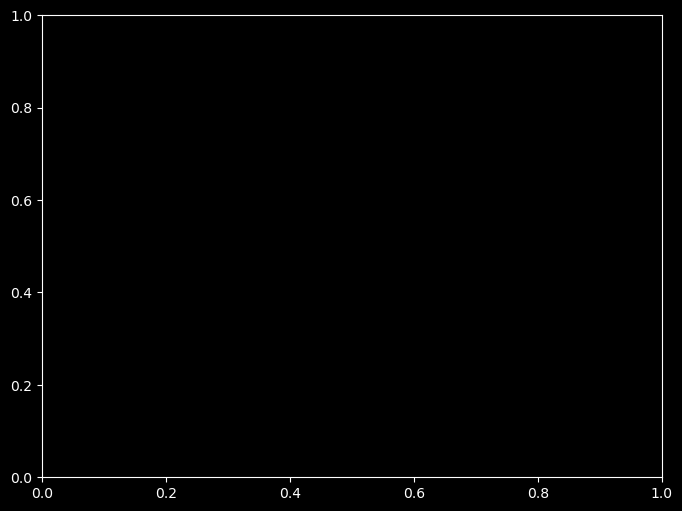

In [ ]:
io = NWBHDF5IO(nwb_path, mode='r')
nwb_ = io.read()

nwb2widget(nwb_)

In [139]:
df_stim = nwb_.trials.to_dataframe()
df_opto = nwb_.get_time_intervals('optogenetics_states').to_dataframe()
df_units = nwb_.units.to_dataframe()

In [140]:
optogenetics_LED_state = []
for i,row in df_stim.iterrows():
    if np.min(np.abs(df_opto.start_time.values - row.start_time))<0.1:
        optogenetics_LED_state.extend([1])
    else:
        optogenetics_LED_state.extend([0])
df_stim['optogenetics_LED_state']= optogenetics_LED_state

## flash responses 
[no probes in this nwb yet having data issue with my local copy]

In [160]:
import dlab.psth_and_raster as psth
from dlab.generalephys import cleanAxes
df1=df_units
df1

,depth,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,spike_times
id,,,,,,,,,
0,921.653447,25.536051,3711.653447,0,1,495.0,39.7,A,"[3386.173221728945, 3386.239688022155, 3386.25..."
1,969.001978,26.680260,3759.001978,0,1,827.5,0.0,A,"[4455.821774831464, 4804.668877247732, 4998.07..."
2,881.196474,28.819949,3671.196474,0,1,840.0,59.0,A,"[5196.214778007007, 5221.6585604913225, 5287.8..."
3,900.895605,28.271477,3690.895605,0,1,594.9,0.0,A,"[5810.06179809548, 6378.027536186321, 6384.207..."
4,955.926077,14.131495,3745.926077,0,1,810.6,47.0,A,"[4980.273137009042, 5093.840808931818, 5267.58..."
...,...,...,...,...,...,...,...,...,...
2164,415.393089,47.161546,805.393089,2,2,1747.9,0.0,C,"[3500.652429949263, 3977.238294823803, 4120.03..."
2165,248.302026,23.623893,638.302026,2,2,3077.9,3.1,C,"[3606.4776747480346, 3725.737318863497, 3859.0..."
2166,153.365269,47.669656,543.365269,2,2,857.6,2.8,C,"[3408.0808037098323, 3501.647791848024, 3523.2..."


In [190]:
df_stim

,start_time,stop_time,stimulus,optogenetics_LED_state,flash_luminance,contrast,temporal_frequency,spatial_frequency,orientation,stimulus_index
id,,,,,,,,,,
0,3570.826467,3573.829202,luminance_flash,0,0,-1,-1,-1,-1,-1
1,3573.820467,3576.823202,luminance_flash,0,1,-1,-1,-1,-1,-1
2,3576.823233,3579.825968,luminance_flash,0,0,-1,-1,-1,-1,-1
3,3579.825867,3582.828602,luminance_flash,0,1,-1,-1,-1,-1,-1
4,3582.828467,3585.831202,luminance_flash,0,0,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
27475,10118.996425,10119.997369,scenes_opto,0,-1,-1,-1,-1,-1,15
27476,10119.997359,10120.998302,scenes_opto,0,-1,-1,-1,-1,-1,16
27477,10120.998259,10121.999202,scenes_opto,0,-1,-1,-1,-1,-1,17


plot one unit
### label==2 "good"
### label==1 "mua"
### label==0 'noise'

In [185]:
df_units[df_units.probe=='A'][df_units.label==2] # these are the "good" labelled units

C:\Users\denmanlab\AppData\Local\Temp\ipykernel_25824\3137238710.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_units[df_units.probe=='A'][df_units.label==2] # these are the "good" labelled units


,depth,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,spike_times
id,,,,,,,,,
29,813.996154,27.528879,3603.996154,2,2,572.8,0.0,A,"[3386.2787936926634, 3386.4762239421048, 3387...."
32,792.803147,41.666452,3582.803147,2,2,1386.1,2.4,A,"[3629.2553374850354, 3629.2592080121462, 3933...."
34,778.075075,32.093488,3568.075075,2,2,1010.5,3.0,A,"[3386.416998203919, 3387.161728179539, 3387.55..."
35,756.210150,48.650015,3546.210150,2,1,1146.8,19.5,A,"[3402.0644048621198, 3402.0902639872365, 3403...."
38,703.155128,25.058841,3493.155128,2,2,848.8,0.0,A,"[3386.1430916773625, 3386.231746768255, 3387.5..."
...,...,...,...,...,...,...,...,...,...
868,298.029164,53.000000,3088.029164,2,2,2094.0,0.0,A,"[3965.679485528516, 4701.734050515822, 4754.55..."
869,266.616984,34.995371,3056.616984,2,2,601.7,1.0,A,"[3386.1092912983468, 3386.150732631745, 3386.1..."
870,254.357973,44.436772,3044.357973,2,2,948.9,3.4,A,"[3420.303129423343, 3424.882863898088, 3426.17..."


In [182]:
df_units[df_units.probe=='B'][df_units.label==2] # these are the "good" labelled units

C:\Users\denmanlab\AppData\Local\Temp\ipykernel_25824\4126575258.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_units[df_units.probe=='B'][df_units.label==2] # these are the "good" labelled units


,depth,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,spike_times
id,,,,,,,,,
888,869.679076,48.180176,3659.679076,2,1,851.3,93.7,B,"[3388.5206636479256, 3391.197604853602, 3391.8..."
889,864.430365,30.358220,3654.430365,2,1,639.8,0.0,B,"[3771.3835849511183, 3773.143149956949, 3897.0..."
896,822.029731,14.116672,3612.029731,2,2,1629.1,0.0,B,"[3771.4030042946342, 3903.5324301203786, 3903...."
897,813.262671,9.263648,3603.262671,2,2,1012.0,9.9,B,"[3386.527765808467, 3387.9267465591915, 3389.8..."
900,854.333044,28.565915,3644.333044,2,2,1404.9,7.5,B,"[3391.217691529946, 3419.4310179129907, 3462.0..."
...,...,...,...,...,...,...,...,...,...
1244,196.996991,27.502660,2986.996991,2,2,691.1,3.7,B,"[3386.1008405506855, 3386.1640368334934, 3386...."
1245,94.615155,33.250051,2884.615155,2,2,1908.3,0.0,B,"[3386.186225602267, 3386.2278003479873, 3386.2..."
1246,39.390282,49.080980,2829.390282,2,2,1046.2,3.0,B,"[3386.2070463417826, 3386.2631021787074, 3386...."


In [187]:
df_units[df_units.probe=='C'][df_units.label==2] # these are the "good" labelled units

C:\Users\denmanlab\AppData\Local\Temp\ipykernel_25824\2433156616.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_units[df_units.probe=='C'][df_units.label==2] # these are the "good" labelled units


,depth,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,spike_times
id,,,,,,,,,
1249,3426.275136,28.650734,3816.275136,2,2,1869.4,8.6,C,"[3386.4247633522677, 3386.758497020752, 3389.9..."
1255,3427.303332,39.781820,3817.303332,2,2,2501.6,0.4,C,"[3386.3611998011324, 3386.4076462384983, 3386...."
1257,3408.330079,50.278029,3798.330079,2,2,1094.5,4.6,C,"[3386.4228614507374, 3386.6796848906847, 3386...."
1264,3400.323943,41.023053,3790.323943,2,2,1304.0,4.9,C,"[3386.1473526624245, 3390.1177763548267, 3390...."
1266,3372.311514,20.448529,3762.311514,2,2,1252.3,2.9,C,"[3386.333271878664, 3386.3353072469686, 3386.3..."
...,...,...,...,...,...,...,...,...,...
2163,408.421533,24.012569,798.421533,2,2,1371.7,0.0,C,"[3390.6747999723775, 3390.690916086558, 3390.8..."
2164,415.393089,47.161546,805.393089,2,2,1747.9,0.0,C,"[3500.652429949263, 3977.238294823803, 4120.03..."
2165,248.302026,23.623893,638.302026,2,2,3077.9,3.1,C,"[3606.4776747480346, 3725.737318863497, 3859.0..."


# .values[::2]
### is Equal too the brightdark flashes

C:\Users\denmanlab\AppData\Local\Temp\ipykernel_25824\2220107913.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe=='A'][df_units.label==2]


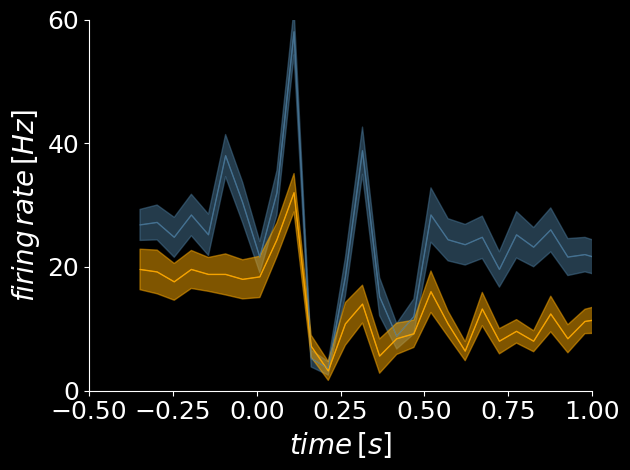

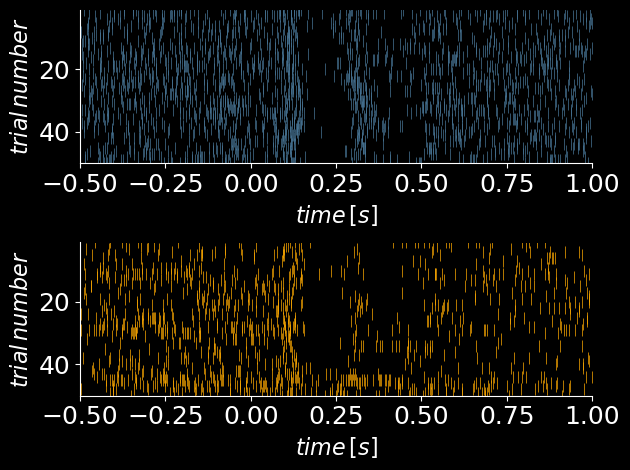

In [168]:
unit=869
df1 = df_units[df_units.probe=='A'][df_units.label==2]
f,ax=plt.subplots(1,1)
psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values[::2],
              ymax=60,binsize=0.05,axes=ax,color='#487697')
psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash_opto') ].start_time.values[::2],
              ymax=60,binsize=0.05,axes=ax,color='#ffaa00')
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.eps')
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.png')

f,ax=plt.subplots(2,1)
psth.raster(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values[::2],
              axes=ax[0],color='#487697',timeDomain=True,post=1.5,ms=8)
psth.raster(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash_opto') ].start_time.values[::2],
              axes=ax[1],color='#ffaa00',timeDomain=True,post=1.5,ms=8)
for ax_ in ax: ax_.set_xlim(-0.5,1.0)
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_raster.eps')

# .values[1::2]
### is Equal too the dark flashes

C:\Users\denmanlab\AppData\Local\Temp\ipykernel_25824\1463742400.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe=='A'][df_units.label==2]


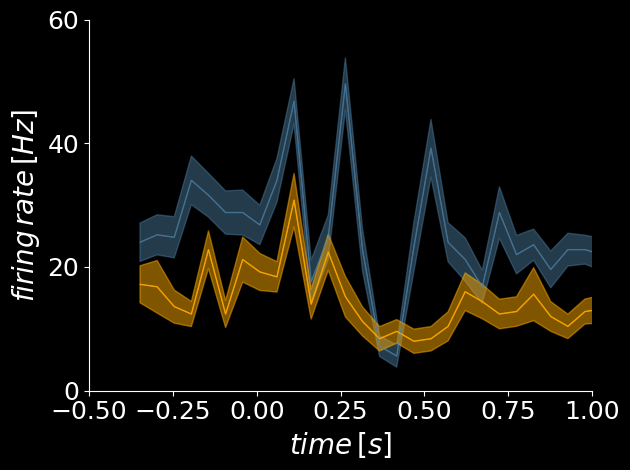

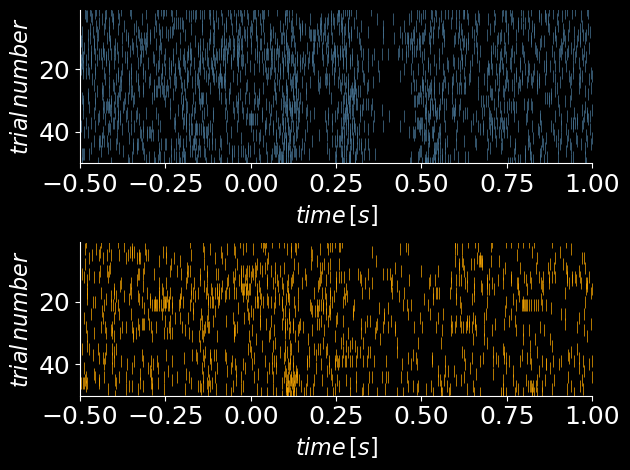

In [146]:
unit=869
df1 = df_units[df_units.probe=='A'][df_units.label==2]
f,ax=plt.subplots(1,1)
psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values[1::2],
              ymax=60,binsize=0.05,axes=ax,color='#487697')
psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash_opto') ].start_time.values[1::2],
              ymax=60,binsize=0.05,axes=ax,color='#ffaa00')
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.eps')
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.png')

f,ax=plt.subplots(2,1)
psth.raster(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values[1::2],
              axes=ax[0],color='#487697',timeDomain=True,post=1.5,ms=8)
psth.raster(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash_opto') ].start_time.values[1::2],
              axes=ax[1],color='#ffaa00',timeDomain=True,post=1.5,ms=8)
for ax_ in ax: ax_.set_xlim(-0.5,1.0)
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_raster.eps')